In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import glob as gb
from tqdm import tqdm
import itertools

In [3]:
#Hyperparameters
resize = 224
learning_rate = 1e-4
EPOCHS = 50
BS = 64
categories = ['acne'  , 'dry' , 'oil']


In [4]:
base_dir = './skin_dataset'
TRAIN_DIR = os.path.join(base_dir, 'train')
TEST_DIR = os.path.join(base_dir, 'test')
VALID_DIR = os.path.join(base_dir, 'valid')

In [5]:
# Check if directories exist
assert os.path.exists(TRAIN_DIR), 'Could not find ' + TRAIN_DIR
assert os.path.exists(TEST_DIR), 'Could not find ' + TEST_DIR
assert os.path.exists(VALID_DIR), 'Could not find ' + VALID_DIR

In [6]:
categories = []
class_count = []
train_exm = 0

for f in tqdm(os.listdir(TRAIN_DIR)):
    folder_path = os.path.join(TRAIN_DIR, f)
    if os.path.isdir(folder_path):
        files = gb.glob(pathname=str(TRAIN_DIR + '/' + f + '/*'))
        categories.append(f)
        class_count.append(len(files))
        train_exm += len(files)

100%|██████████| 4/4 [00:00<00:00, 731.77it/s]


In [7]:
print(f"Categories: {categories}")
print(f"Class count: {class_count}")

Categories: ['dry', 'acne', 'oil']
Class count: [705, 702, 706]


([0, 1, 2], [Text(0, 0, 'dry'), Text(1, 0, 'acne'), Text(2, 0, 'oil')])

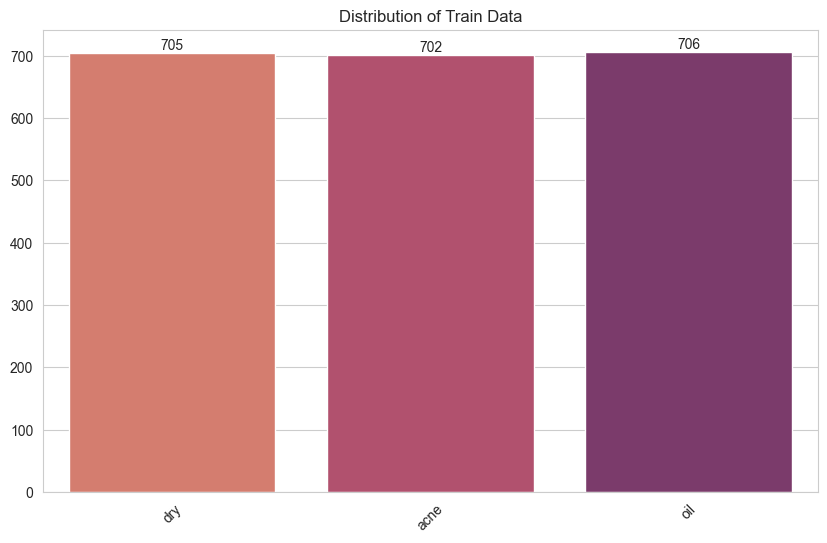

In [8]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=categories, y=class_count, hue=categories, palette='flare', dodge=False)
# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribution of Train Data')
plt.xticks(rotation=45)

In [148]:
if ax.legend_ is not None:
    ax.legend_.remove()

plt.show()
print(f"Total number of examples in the dataset: {train_exm}")

Total number of examples in the dataset: 2113


In [149]:
data = []
labels = []

for c in categories:
    path = os.path.join(TRAIN_DIR, c)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        img = Image.open(img_path).convert("RGB")
        img = img.resize((resize, resize))
        img = np.array(img)
        data.append(img)
        labels.append(c)

data = np.array(data, dtype="float32")
labels = np.array(labels)

  0%|          | 0/705 [00:00<?, ?it/s]

100%|██████████| 706/706 [00:03<00:00, 222.63it/s]


In [150]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)

In [151]:
torch.manual_seed(107)
np.random.seed(107)

In [152]:
# Transformations for training and validation datasets (Augmentation and Normalization)
transform_train = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(15, shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

transform_valid = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [9]:
class SkinDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for idx, category in enumerate(os.listdir(data_dir)):
            category_path = os.path.join(data_dir, category)
            if os.path.isdir(category_path):
                for img_path in gb.glob(pathname=category_path + '/*'):
                    self.image_paths.append(img_path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [154]:
# Split data into training, validation, and testing
train_dataset = CustomDataset(TRAIN_DIR, categories, transform=transform_train)
valid_dataset = CustomDataset(VALID_DIR, categories, transform=transform_valid)
test_dataset = CustomDataset(TEST_DIR, categories, transform=transform_valid)

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

In [155]:
# Load pre-trained VGG16 model
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

In [156]:
model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=len(categories))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [157]:
model.classifier[5] = nn.Dropout(0.6)  
model.classifier[3] = nn.Dropout(0.6) 

In [158]:
for param in model.features.parameters():
    param.requires_grad = False

In [159]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [160]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [161]:
# Training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=EPOCHS):
    best_acc = 0.0
    print("Starting training...")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valid_loader)
        val_acc = correct / total

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}", flush=True)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'VGG16_model.pth')

    print("Training complete!")

In [162]:
# training
train_model(model, train_loader, valid_loader, criterion, optimizer)

Starting training...
Epoch [1/50], Train Loss: 1.7488, Train Acc: 0.3223, Val Loss: 1.0257, Val Acc: 0.4839
Epoch [2/50], Train Loss: 1.5744, Train Acc: 0.3857, Val Loss: 1.0075, Val Acc: 0.5392
Epoch [3/50], Train Loss: 1.4237, Train Acc: 0.4094, Val Loss: 0.9782, Val Acc: 0.5668
Epoch [4/50], Train Loss: 1.2763, Train Acc: 0.4434, Val Loss: 0.9508, Val Acc: 0.5668
Epoch [5/50], Train Loss: 1.2379, Train Acc: 0.4643, Val Loss: 0.8911, Val Acc: 0.6221
Epoch [6/50], Train Loss: 1.1923, Train Acc: 0.4808, Val Loss: 0.8908, Val Acc: 0.6221
Epoch [7/50], Train Loss: 1.1379, Train Acc: 0.5102, Val Loss: 0.8600, Val Acc: 0.6313
Epoch [8/50], Train Loss: 1.1346, Train Acc: 0.5305, Val Loss: 0.8387, Val Acc: 0.6452
Epoch [9/50], Train Loss: 1.0496, Train Acc: 0.5660, Val Loss: 0.8089, Val Acc: 0.6636
Epoch [10/50], Train Loss: 0.9614, Train Acc: 0.5878, Val Loss: 0.8043, Val Acc: 0.6452
Epoch [11/50], Train Loss: 0.9739, Train Acc: 0.5831, Val Loss: 0.8145, Val Acc: 0.6636
Epoch [12/50], Train

In [163]:
# Model evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [164]:
# Evaluation model
preds, labels = evaluate_model(model, test_loader)
print(classification_report(labels, preds, target_names=categories))

              precision    recall  f1-score   support

         dry       0.67      0.81      0.73        27
        acne       0.81      0.76      0.79        51
         oil       0.77      0.71      0.74        42

    accuracy                           0.76       120
   macro avg       0.75      0.76      0.75       120
weighted avg       0.76      0.76      0.76       120



In [165]:
# classification report and confusion matrix
cm = confusion_matrix(labels, preds)

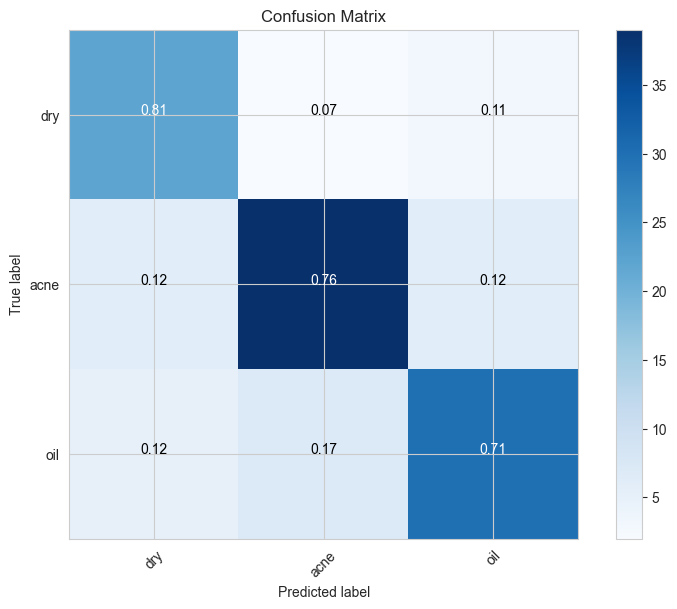

In [166]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=categories, normalize=True)
plt.show()